# Importing Libraries

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter 
from sklearn import preprocessing
import re
from wordcloud import WordCloud
import string
from nltk.corpus import stopwords
import matplotlib.cm as cm
from matplotlib import rcParams
%matplotlib inline
from gensim.models import ldamodel
import nltk
from nltk.tokenize import RegexpTokenizer
import gensim.corpora;
from sklearn.preprocessing import normalize
from gensim.models import CoherenceModel

D:\anaconda3\envs\lda2vec\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
import pyLDAvis
#import pyLDAvis.gensim
import pyLDAvis.gensim_models
import gensim
pyLDAvis.enable_notebook()

import warnings
warnings.filterwarnings("ignore")

# Loading 20 news dataset


In [15]:
from sklearn.datasets import fetch_20newsgroups
remove=('headers', 'footers', 'quotes')
texts = fetch_20newsgroups(subset='all', remove=remove).data

# Saving the 20 news data in the dataframe


In [16]:
data=pd.DataFrame(texts)


# Giving header as News_text


In [17]:
data=data.rename(columns={0:'News_text'})


# Data Analysis, Preprocessing and Cleaning


### Lenght of data


In [18]:
len(data)

18846

### News text in lower case


In [19]:
data['News_text']=data['News_text'].str.lower()


In [20]:
data['News_text'].head()


0    \n\ni am sure some bashers of pens fans are pr...
1    my brother is in the market for a high-perform...
2    \n\n\n\n\tfinally you said what you dream abou...
3    \nthink!\n\nit's the scsi card doing the dma t...
4    1)    i have an old jasmine drive which i cann...
Name: News_text, dtype: object

### all columns


In [21]:
data.columns


Index(['News_text'], dtype='object')

### data types of all columns


In [22]:
data.dtypes


News_text    object
dtype: object

### Checking Null values


In [52]:
print(data[data.isnull().any(axis=1)])


Empty DataFrame
Columns: [News_text]
Index: []


### Count of Null values


In [24]:
np.sum(data.isnull().any(axis=1))


0

### Data information


In [25]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18846 entries, 0 to 18845
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   News_text  18846 non-null  object
dtypes: object(1)
memory usage: 147.4+ KB


# Remving the numbers from the news text


In [26]:
for letter in '1234567890.(/':
    data['News_text']= data['News_text'].str.replace(letter,'')

# Remving the single letters (like, "u", "w" etc) from the text


In [27]:
data['News_text']=data['News_text'].str.replace(r'\b\w\b','').str.replace(r'\s+', ' ')


### Getting Tokenization of News


In [28]:
tokenizer = RegexpTokenizer(r'\w+')
data['News_text'] = data['News_text'].apply(tokenizer.tokenize)

In [29]:
data['News_text'].head()


0    [am, sure, some, bashers, of, pens, fans, are,...
1    [my, brother, is, in, the, market, for, high, ...
2    [finally, you, said, what, you, dream, about, ...
3    [think, it, the, scsi, card, doing, the, dma, ...
4    [have, an, old, jasmine, drive, which, cannot,...
Name: News_text, dtype: object

### Stop words of english


In [30]:
stopwords_list = stopwords.words('english')

In [31]:
len(stopwords_list)


179

### Removing Stops words from reviews
 

In [32]:
data['News_text']=data['News_text'].apply(lambda x: [item for item in x if item not in stopwords_list])


In [33]:
data['News_text'].head()


0    [sure, bashers, pens, fans, pretty, confused, ...
1    [brother, market, high, performance, video, ca...
2    [finally, said, dream, mediterranean, new, are...
3    [think, scsi, card, dma, transfers, disks, scs...
4    [old, jasmine, drive, cannot, use, new, system...
Name: News_text, dtype: object

### Description of news text information


In [34]:
all_words = [word for tokens in data['News_text'] for word in tokens]
sentence_lengths = [len(tokens) for tokens in data['News_text']]

VOCAB = sorted(list(set(all_words)))

print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

1904041 words total, with a vocabulary size of 116204
Max sentence length is 16291


### Top 20 words in News text
 

In [35]:
counter = Counter(all_words)


In [36]:
counter.most_common(20)


[('ax', 62471),
 ('one', 10385),
 ('would', 10185),
 ('like', 6505),
 ('people', 6446),
 ('get', 5826),
 ('know', 5756),
 ('also', 5585),
 ('use', 5015),
 ('think', 4989),
 ('time', 4831),
 ('max', 4653),
 ('could', 4174),
 ('us', 4097),
 ('new', 4066),
 ('well', 4055),
 ('may', 4031),
 ('good', 3897),
 ('even', 3794),
 ('see', 3623)]

In [37]:
counted_words = Counter(all_words)

words = []
counts = []
for letter, count in counted_words.most_common(25):
    words.append(letter)
    counts.append(count)

<BarContainer object of 25 artists>

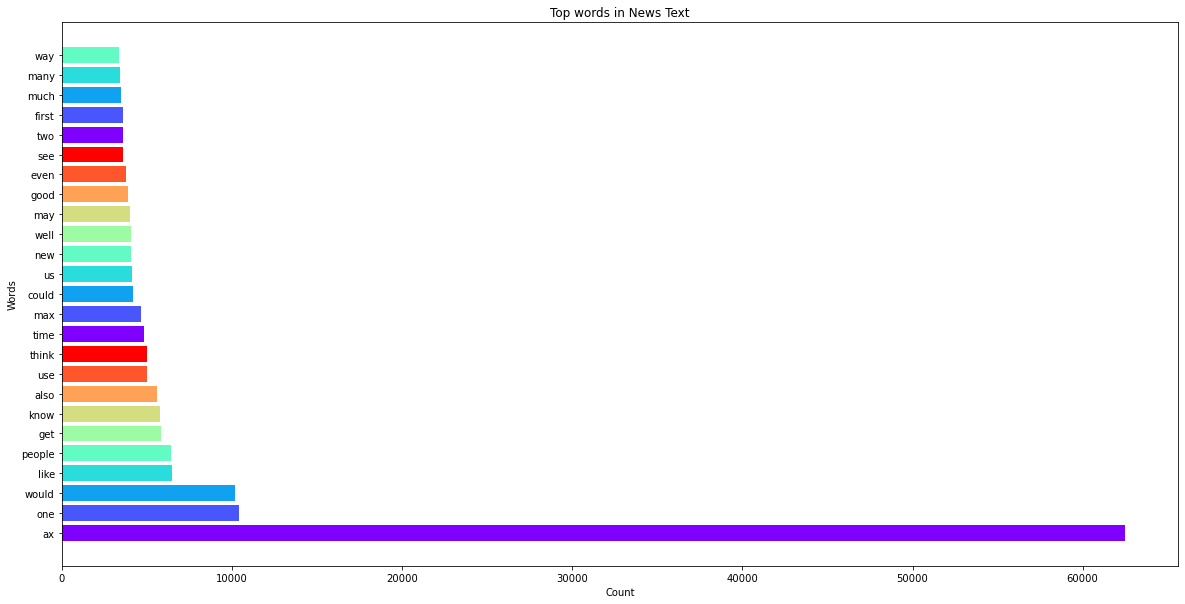

In [38]:
colors = cm.rainbow(np.linspace(0, 1, 10))
rcParams['figure.figsize'] = 20, 10

plt.title('Top words in News Text')
plt.xlabel('Count')
plt.ylabel('Words')
plt.barh(words, counts, color=colors)

### Word cloud of News Text


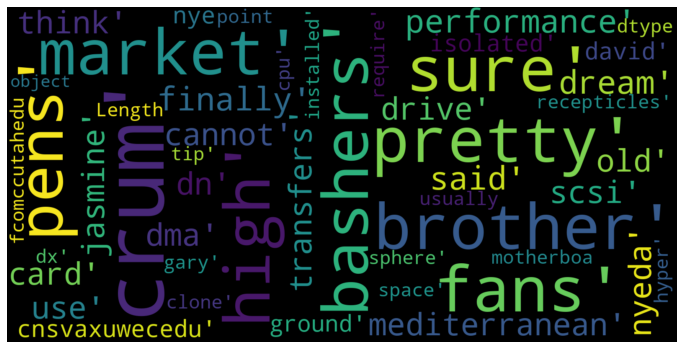

In [39]:
neg =data['News_text']
neg_string = []
for t in neg:
    neg_string.append(t)
neg_string = pd.Series(neg_string).map(str)
neg_string=str(neg_string)


wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Function to get the topics using LDA model


In [40]:
def LDA_topics(model, num_topics):
    word_dict = {};
    for i in range(num_topics):
        words = model.show_topic(i, topn = 10);
        word_dict['Words of Topic ' + '{:02d}'.format(i+1)] = [i[0] for i in words];
    return pd.DataFrame(word_dict)

# Getting the news text in data_text
 

In [41]:
data_text=pd.DataFrame(data['News_text'])


# Rename the News_text to News_Text


In [42]:
data_text=data_text.rename(columns={'News_text':'News_Text'})


# Creating for training on LDA model with three topics


In [43]:
train_ = [value[0] for value in data_text.iloc[0:].values]


# Selecting the number of topics

In [44]:
num_topics = 20

# getting dictionary of the text using gensim


In [45]:
id2word1 = gensim.corpora.Dictionary(train_)


# getting the word vector


In [46]:
corpus1 = [id2word1.doc2bow(text) for text in train_]


# Calling the LDA model and feeding the calculated text, dictionary and topics


In [47]:
lda2vec = ldamodel.LdaModel(corpus=corpus1, id2word=id2word1, num_topics=num_topics)


# Calling LDA_topics function and using lda2vec with selective topics


In [53]:
print(LDA_topics(lda2vec, num_topics))


  Words of Topic 01 Words of Topic 02 Words of Topic 03 Words of Topic 04  \
0              list                ax                ra             space   
1             would               max            wicked              data   
2              also                bf     reincarnation          research   
3         president                gv            morgan           program   
4            people                pl              ages            center   
5               one                di            darren         available   
6       information               giz          prophecy        university   
7               may                tm          darkness              nasa   
8               new                wm            harley             earth   
9        conference                ei           kidding       information   

  Words of Topic 05 Words of Topic 06 Words of Topic 07 Words of Topic 08  \
0               key                mp             would          armenian  

# Computing the Topic Coherence with 20
 

In [54]:
coherence_using_lda2vec = CoherenceModel(model=lda2vec, texts=train_, dictionary=id2word1, coherence='c_v')
coherence = coherence_using_lda2vec.get_coherence()
print('Coherence Score: ', round(coherence, 3))

Coherence Score:  0.611
